# Running on new images
This notebook will walk you step by step through the process of using a pre-trained model to detect traffic signs in an image.

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import glob as glob

# Environment setup

In [2]:
%matplotlib inline
import sys
# Append your Tensorflow object detection and darkflow directories to your path
# sys.path.append('PATH_TO_TENSORFLOW_OBJECT_DETECTION_FOLDER') # ~/tensorflow/models/research/object_detection
# sys.path.append('PATH_TO_DARKFLOW_FOLDER') # ~/darkflow

# sys.path.remove('/Users/hiteshochani/cv/tensorflow/models/research/object_detection')
# sys.path.remove('/Users/hiteshochani/cv/darkflow/darkflow')
sys.path.append('/Users/hiteshochani/cv/tensorflow/models/research/object_detection') # ~/tensorflow/models/research/object_detection
sys.path.append('/Users/hiteshochani/cv/darkflow/darkflow') # ~/darkflow


print(sys.path)

from utils import label_map_util
from utils import visualization_utils as vis_util

['', '/Users/hiteshochani/anaconda3/envs/cv/lib/python36.zip', '/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6', '/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/lib-dynload', '/Users/hiteshochani/.local/lib/python3.6/site-packages', '/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages', '/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/object_detection-0.1-py3.6.egg', '/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/IPython/extensions', '/Users/hiteshochani/.ipython', '/Users/hiteshochani/cv/tensorflow/models/research/object_detection', '/Users/hiteshochani/cv/darkflow/darkflow']


# Tensorflow Object Detection API

## Model preparation 

In [18]:
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous'
# MODEL_NAME = 'faster_rcnn_resnet_101'
# MODEL_NAME = 'faster_rcnn_resnet50'
# MODEL_NAME = 'faster_rcnn_inception_v2'
# MODEL_NAME = 'rfcn_resnet101'
# MODEL_NAME = 'ssd_inception_v2'
# MODEL_NAME = 'ssd_mobilenet_v1'

In [19]:
# Path to frozen detection graph. This is the actual model that is used for the traffic sign detection.
MODEL_PATH = os.path.join('/Users/hiteshochani/cv/project/pretrained_model_sign/models/', MODEL_NAME)
PATH_TO_CKPT = os.path.join(MODEL_PATH,'inference_graph/frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
# PATH_TO_LABELS = os.path.join('/Users/hiteshochani/cv/project/pretrained_model_sign/gtsdb_data/', 'gtsdb3_label_map.pbtxt')
PATH_TO_LABELS = os.path.join('scripts', 'gtsdb3_label_map.pbtxt')


NUM_CLASSES = 3

## Load a (frozen) Tensorflow model into memory

In [20]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `2`, we know that this corresponds to `mandatory`.

In [21]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)

item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## Helper code

In [22]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## Detection

In [23]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, '*.png'))

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

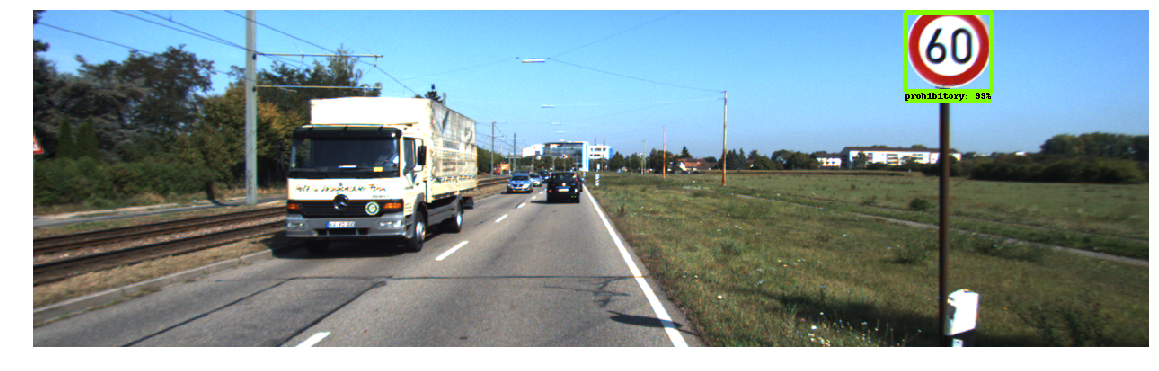

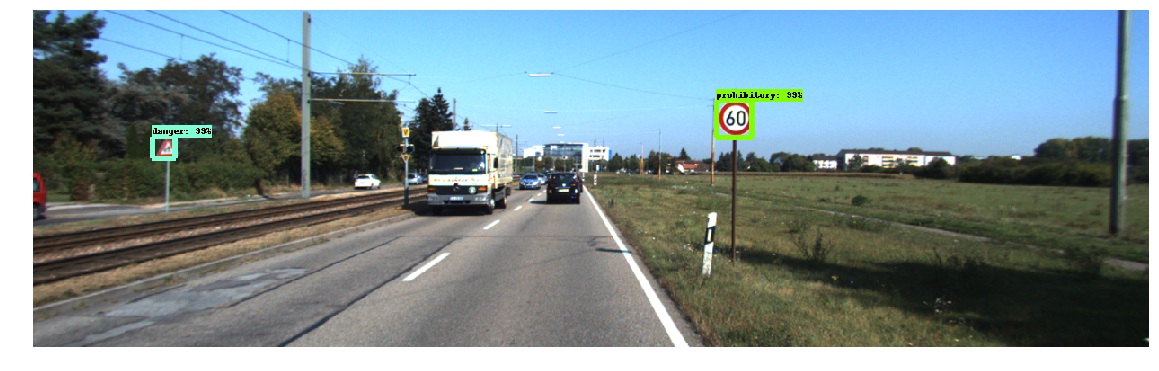

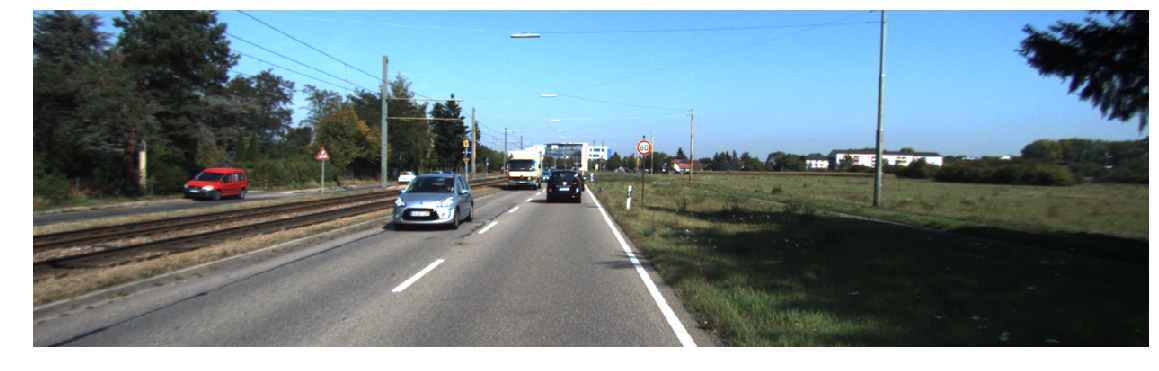

In [24]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGE_PATHS):
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=6)
            plt.figure(idx, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(image_np)

# Darkflow

## Model preparation 

In [25]:
from darkflow.net.build import TFNet
import cv2

MODEL_NAME = 'yolo_v2'
MODEL_PATH = os.path.join('/Users/hiteshochani/cv/project/pretrained_model_sign/models/', MODEL_NAME)

options = {'model': os.path.join(MODEL_PATH, '{}.cfg'.format(MODEL_NAME)),
           'labels': os.path.join(MODEL_PATH, 'labels.txt'),
           'backup': MODEL_PATH,
           'load' : 50500,
           'threshold': 0.5,
           'gpu' : 1.0}

tfnet = TFNet(options)

Parsing /Users/hiteshochani/cv/project/pretrained_model_sign/models/yolo_v2/yolo_v2.cfg
Loading None ...
Finished in 0.0003521442413330078s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)


NotFoundError: Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

/Users/hiteshochani/cv/project/pretrained_model_sign/models/yolo_v2/yolo_v2-50500.data-00000-of-00001; No such file or directory
	 [[node save/RestoreV2_247 (defined at /Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/utils/loader.py:89)  = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_247/tensor_names, save/RestoreV2_247/shape_and_slices)]]

Caused by op 'save/RestoreV2_247', defined at:
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/asyncio/base_events.py", line 1434, in _run_once
    handle._run()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2901, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2961, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-25-e872e97ffc3e>", line 14, in <module>
    tfnet = TFNet(options)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/net/build.py", line 76, in __init__
    self.setup_meta_ops()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/net/build.py", line 151, in setup_meta_ops
    if self.FLAGS.load != 0: self.load_from_ckpt()
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/net/help.py", line 34, in load_from_ckpt
    except: load_old_graph(self, load_point)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/net/help.py", line 45, in load_old_graph
    ckpt_loader = create_loader(ckpt)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/utils/loader.py", line 105, in create_loader
    return load_type(path, cfg)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/utils/loader.py", line 19, in __init__
    self.load(*args)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/utils/loader.py", line 89, in load
    saver = tf.train.import_meta_graph(meta)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1674, in import_meta_graph
    meta_graph_or_file, clear_devices, import_scope, **kwargs)[0]
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1696, in _import_meta_graph_with_return_elements
    **kwargs))
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/framework/meta_graph.py", line 806, in import_scoped_meta_graph_with_return_elements
    return_elements=return_elements)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 442, in import_graph_def
    _ProcessNewOps(graph)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/framework/importer.py", line 234, in _ProcessNewOps
    for new_op in graph._add_new_tf_operations(compute_devices=False):  # pylint: disable=protected-access
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3440, in _add_new_tf_operations
    for c_op in c_api_util.new_tf_operations(self)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3440, in <listcomp>
    for c_op in c_api_util.new_tf_operations(self)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3299, in _create_op_from_tf_operation
    ret = Operation(c_op, self)
  File "/Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): Restoring from checkpoint failed. This is most likely due to a Variable name or other graph key that is missing from the checkpoint. Please ensure that you have not altered the graph expected based on the checkpoint. Original error:

/Users/hiteshochani/cv/project/pretrained_model_sign/models/yolo_v2/yolo_v2-50500.data-00000-of-00001; No such file or directory
	 [[node save/RestoreV2_247 (defined at /Users/hiteshochani/anaconda3/envs/cv/lib/python3.6/site-packages/darkflow/utils/loader.py:89)  = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2_247/tensor_names, save/RestoreV2_247/shape_and_slices)]]


## Helper code

In [ ]:
def plot_rectangle(bbox, ax, class_name, edgecolor, confidence=None):
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]
    left = xmin
    right = xmax
    top = ymin
    bot = ymax
    ax.add_patch(
        plt.Rectangle((left, top),
                      right-left,
                      bot-top, fill=False,
                      edgecolor=edgecolor, linewidth=3.5)
        )
    label = '{:s}'.format(class_name)
    label_pos_y = top-10
    if confidence:
        label += ' {0:.2f}'.format(confidence)
        label_pos_y = bot+20
    ax.text(left, label_pos_y,label,
            bbox=dict(facecolor=edgecolor, alpha=0.5),
            fontsize=14, color='white')

In [11]:
def get_label_id(label_name):
    for category in categories:
        if category['name'] == label_name:
            return category['id']

## Detection

NameError: name 'tfnet' is not defined

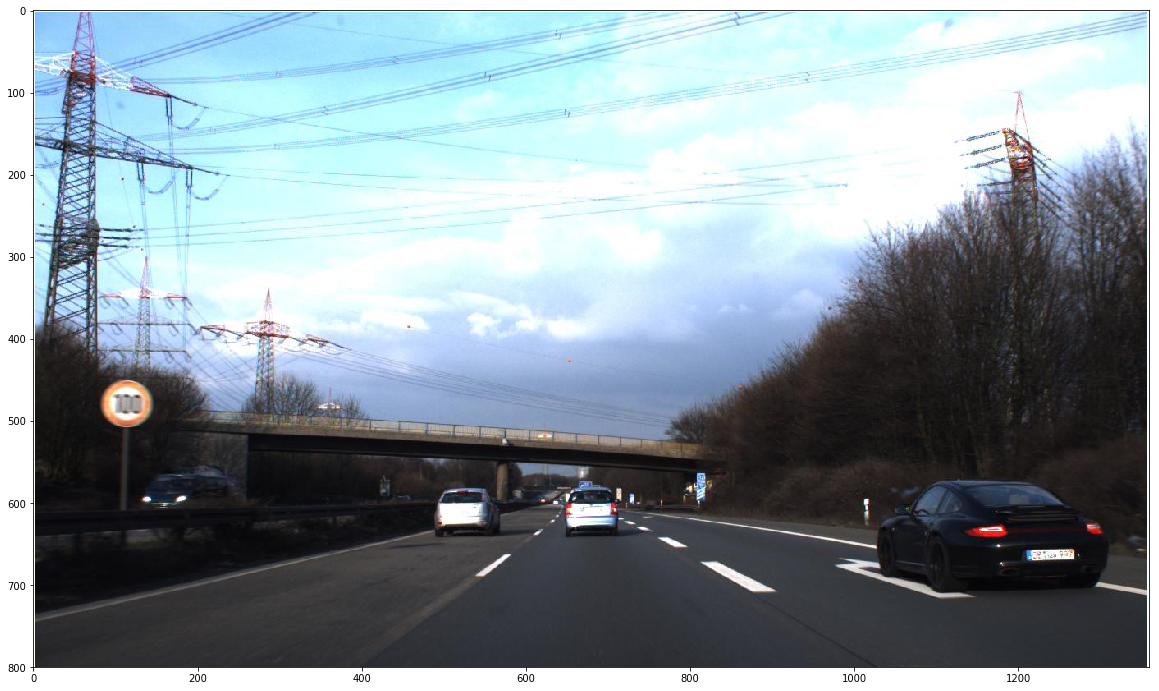

In [12]:
min_score_thresh = 0.5
for image_path in TEST_IMAGE_PATHS:
    fig, ax = plt.subplots(figsize=(20, 20))
    image = Image.open(image_path)
    image_name = os.path.basename(image_path)
    width, height = image.size
    ax.imshow(image)
    
    image_np = load_image_into_numpy_array(image)
    image_np = image_np[:,:,::-1] # rgb -> bgr
    pred_results = tfnet.return_predict(image_np)

    for idx, det in enumerate(pred_results):
        score = det['confidence']
        if score > min_score_thresh:
            bbox = det['topleft']['x'], det['topleft']['y'], det['bottomright']['x'], det['bottomright']['y']
            label = get_label_id(det['label'])
            plot_rectangle(bbox,ax,category_index[label]['name'],'red', score)
    plt.draw()
    fig.tight_layout()
    plt.axis('off')
    plt.show()